In [1]:
import sys
sys.path.append('../..')

In [2]:
import sbi4abm.sbi
from sbi4abm.sbi import analysis, utils
from sbi4abm.utils import sampling, plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import seaborn as sns
import torch.nn.functional as F

/home/pmms2/sbi4abm/py_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
matplotlib.rc('text', usetex=True)
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "serif"
})
plt.rcParams.update({
    'text.latex.preamble':r"\usepackage{amsmath}"+"\n"+r"\usepackage{bm}"
})

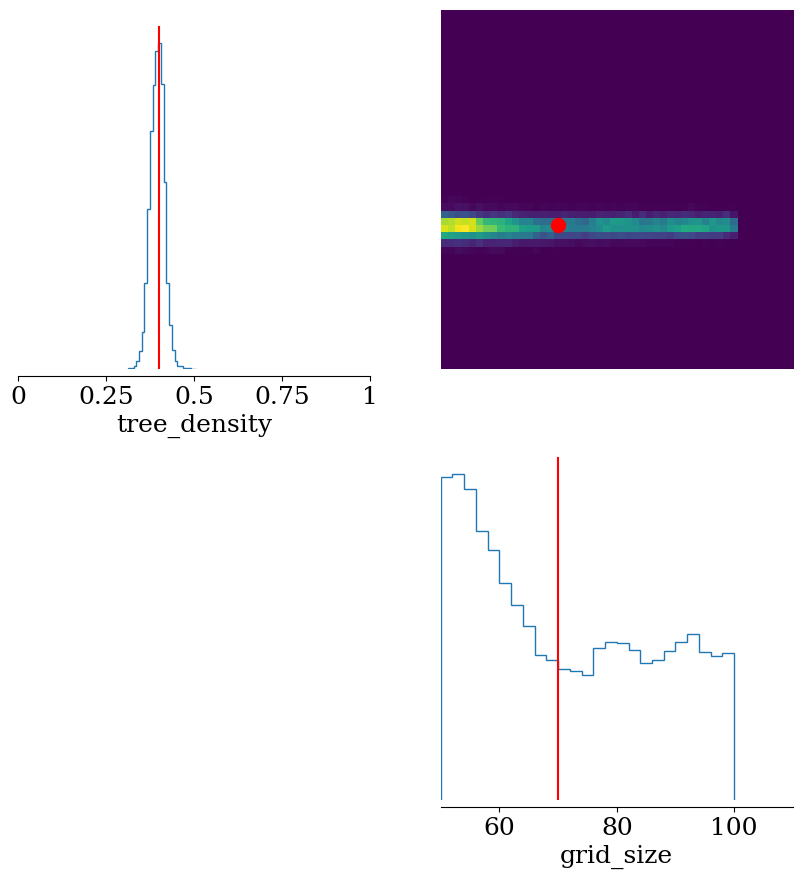

In [5]:
fire = np.loadtxt("../../exp_dir/fire/1712237603.7875483/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(fire, limits=[[0,1], [50,110]], points=[np.array([0.4, 70])],
                      points_colors='r', labels=["tree_density", "grid_size"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})


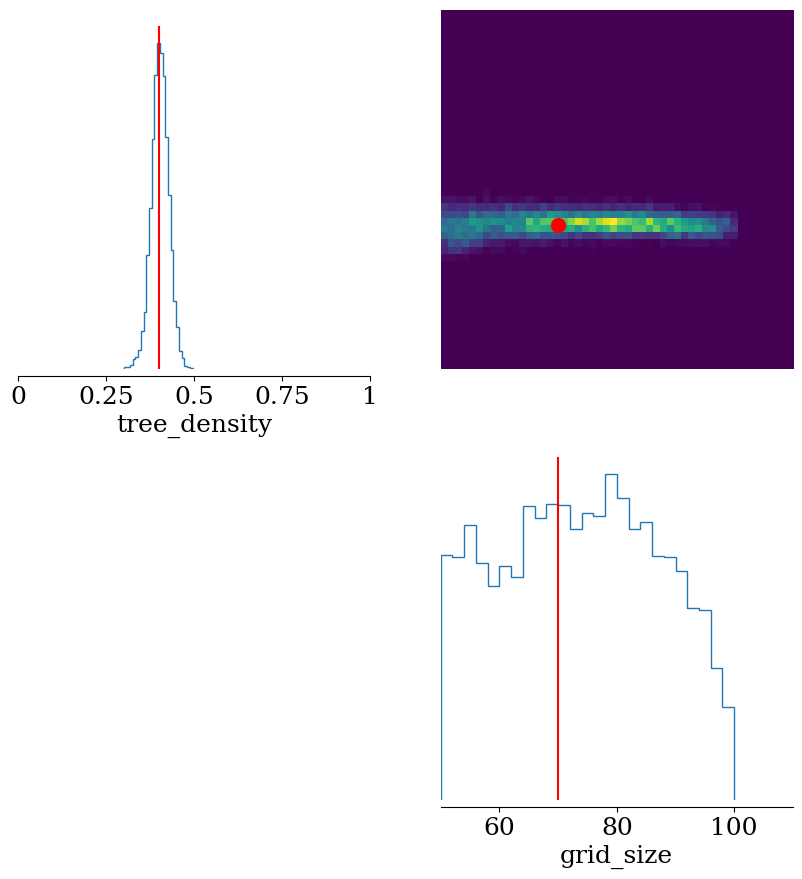

In [6]:
fire = np.loadtxt("../../exp_dir/fire/maf_100000/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(fire, limits=[[0,1], [50,110]], points=[np.array([0.4, 70])],
                      points_colors='r', labels=["tree_density", "grid_size"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})


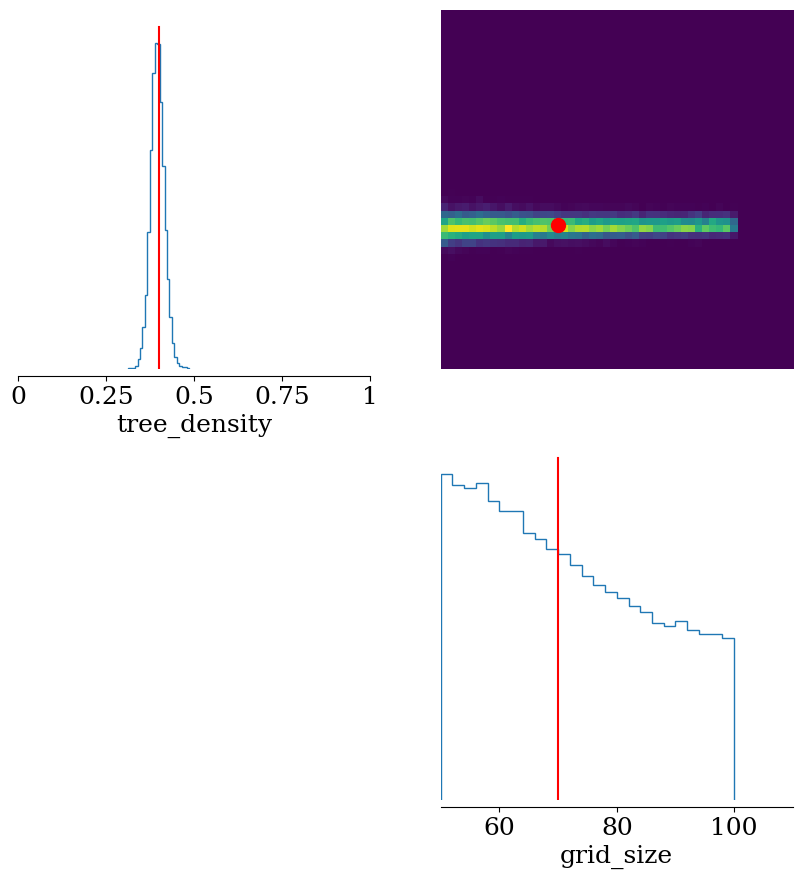

In [7]:
# new resnet arch
fire = np.loadtxt("../../exp_dir/fire/1714837329.4450836/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(fire, limits=[[0,1], [50,110]], points=[np.array([0.4, 70])],
                      points_colors='r', labels=["tree_density", "grid_size"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})


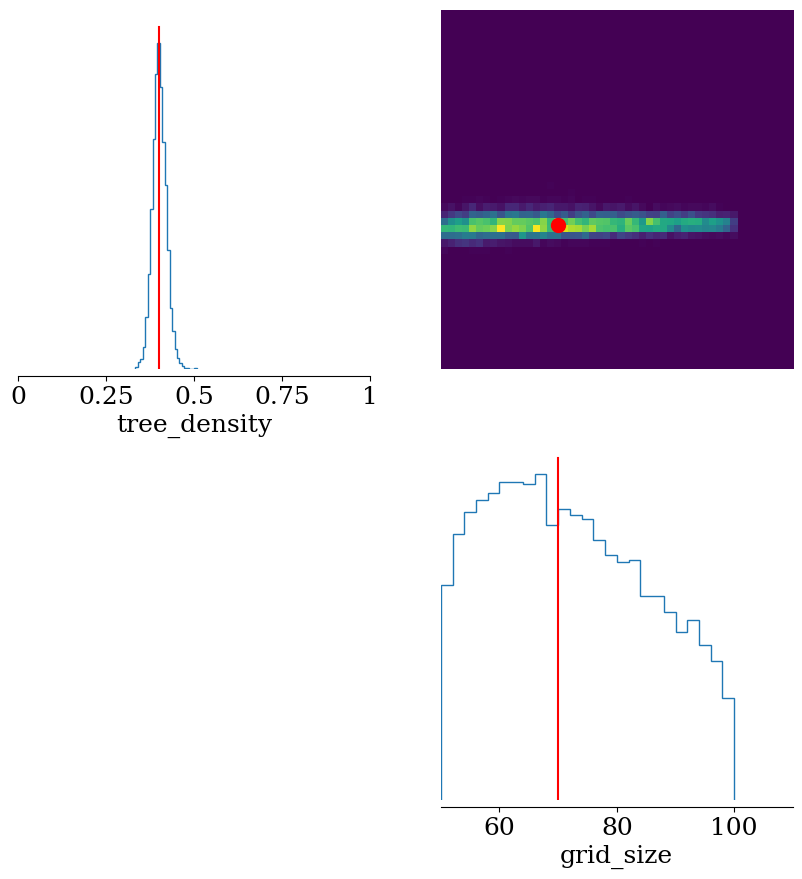

In [4]:
# maf_s new final arch
fire = np.loadtxt("../../exp_dir/fire/1716017330.7123892/samples.txt")
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(fire, limits=[[0,1], [50,110]], points=[np.array([0.4, 70])],
                      points_colors='r', labels=["tree_density", "grid_size"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})


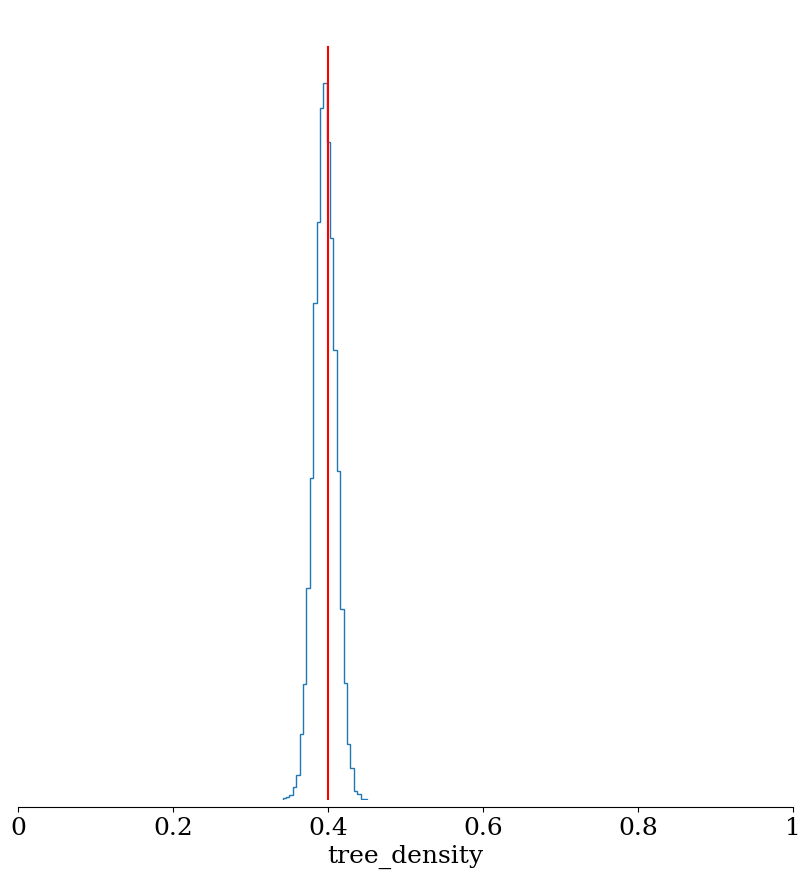

In [4]:
# maf_s new final arch with only tree_density
fire = np.loadtxt("../../exp_dir/fire/1716105878.6067152/samples.txt")[:, np.newaxis]
plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(fire, limits=[[0,1]], points=[np.array([0.4])],
                      points_colors='r', labels=["tree_density"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})


# MAP

In [9]:
from sbi4abm.utils import io

firef = io.load_task('fire')

file_name = "1716017330.7123892"
with open(f"../../exp_dir/fire/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

In [10]:
# Define the negative log-posterior function for minimization
def neg_log_posterior(theta, posterior, observed_data):
    theta = torch.tensor(theta).float()
    return -posterior.log_prob(theta, x=observed_data).item()

In [11]:
from scipy.optimize import minimize

# observed data
final = firef[2]
observation_burned_percentage = final[-1]
observation_burned_percentage = torch.tensor([observation_burned_percentage])

initial_theta = firef[1].mean.numpy()
print(initial_theta)

# Optimize to find the MAP estimate
result = minimize(neg_log_posterior, initial_theta, args=(posterior, observation_burned_percentage), method='L-BFGS-B')
map_estimate = result.x

print(f"MAP estimate: {map_estimate}")

[ 0.55 75.  ]
MAP estimate: [ 0.55000001 75.        ]


In [12]:
true_theta = torch.tensor(firef[3])
map_estimate = torch.tensor(map_estimate)
print(true_theta)
print(map_estimate)
loss = F.mse_loss(map_estimate, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

tensor([ 0.4000, 70.0000], dtype=torch.float64)
tensor([ 0.5500, 75.0000], dtype=torch.float64)
Loss between mean theta and true theta: 12.51125000178814


In [13]:
y_star = firef[0](map_estimate.tolist())
y_star = torch.tensor([y_star[0][-1]])
print(y_star)
print(observation_burned_percentage)

THETAs:  {'Tree density': 0.550000011920929, 'size': 75, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.339657
Simulation finished
tensor([0.9906])
tensor([0.4382], dtype=torch.float64)


In [14]:
import torch.nn.functional as F

def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)


# Compute the loss
loss = loss_function(y_star, observation_burned_percentage)

print(f"Loss: {loss.item()}")

Loss: 0.30511704754533914


# Mean

In [15]:
# Generate samples from the posterior
num_samples = 1000  # Number of samples to draw
posterior_samples = posterior.sample((num_samples,), x=observation_burned_percentage)

# Compute the mean of the samples
mean_estimate = posterior_samples.mean(dim=0)
print(f"Mean estimate: {mean_estimate}")

Drawing 1000 posterior samples: 10534it [00:00, 53980.14it/s]           

Mean estimate: tensor([ 0.4004, 72.4260])


In [16]:
# Compute statistics about the sampled theta values
posterior_samples_np = posterior_samples.numpy()
mean_theta = np.mean(posterior_samples_np, axis=0)
std_theta = np.std(posterior_samples_np, axis=0)
lower_bound_theta = np.percentile(posterior_samples_np, 2.5, axis=0)
upper_bound_theta = np.percentile(posterior_samples_np, 97.5, axis=0)

print(f"Mean of theta: {mean_theta}")
print(f"Standard deviation of theta: {std_theta}")
print(f"95% credible interval for theta: [{lower_bound_theta}, {upper_bound_theta}]")

Mean of theta: [ 0.40035465 72.425995  ]
Standard deviation of theta: [ 0.01895398 13.320192  ]
95% credible interval for theta: [[ 0.36433207 51.37399569], [ 0.43891192 96.944277  ]]


In [18]:
true_theta = torch.tensor(firef[3])
mean_theta = torch.tensor(mean_theta)
print(true_theta)
print(mean_theta)
loss = F.mse_loss(mean_theta, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

tensor([ 0.4000, 70.0000], dtype=torch.float64)
tensor([ 0.4004, 72.4260])
Loss between mean theta and true theta: 2.9427256249144484


/tmp/ipykernel_2247377/2402077806.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_theta = torch.tensor(mean_theta)


In [19]:
y_star = firef[0](mean_estimate)
y_star = torch.tensor([y_star[0][-1]])
print(y_star)
print(observation_burned_percentage)

THETAs:  {'Tree density': 0.40035417675971985, 'size': 72, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.136390
Simulation finished
tensor([0.3272])
tensor([0.4382], dtype=torch.float64)


In [20]:
def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)


# Compute the loss
loss = loss_function(y_star, observation_burned_percentage)

print(f"Loss: {loss.item()}")

Loss: 0.01232568380801171


# Posterior Predictive Checks

In [30]:
from sbi4abm.utils import io

firef = io.load_task('fire')

In [31]:
idxs = np.random.randint(fire.shape[0], size=1000)

### Posterior Predictives

In [32]:
pps = []
for idx in idxs:
    data = firef[0](list(fire[idx]))
    pps.append(data)

THETAs:  {'Tree density': 0.41635268926620483, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.222827
Simulation finished
THETAs:  {'Tree density': 0.4178897440433502, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.196126
Simulation finished
THETAs:  {'Tree density': 0.3987163007259369, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.422615
Simulation finished
THETAs:  {'Tree density': 0.41578802466392517, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.195812
Simulation finished
THETAs:  {'Tree density': 0.41193217039108276, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.197192
Simulation finished
THETAs:  {'Tree density': 0.40638571977615356, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.186877
Simulation finished
THETAs:  {'Tree density': 0.40073999762535095, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.183197
Simulation finished
THETAs:  {'Tree density': 0.3851081430912018, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.163967
Simulat

In [33]:
posterior_burned_percentage = []

for pp in pps:
    if isinstance(pp, torch.Tensor):
        pp = pp.detach().cpu().numpy()

    posterior_burned_percentage.append(pp[0][-1])

    # sx = np.concatenate([
    #     np.array([overall_coherence]),  # Make scalar a 1D array
    #     mean_opinions.flatten(),  # Already 1D, flatten() is optional
    #     variance_opinions.flatten()  # Already 1D, flatten() is optional
    # ])

### Prior Predictives

In [34]:
pps_ = []
for idx in idxs:
    data = firef[0](list(firef[1].sample().tolist()))
    pps_.append(data)

THETAs:  {'Tree density': 0.5265249013900757, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.288050
Simulation finished
THETAs:  {'Tree density': 0.4738241136074066, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.223992
Simulation finished
THETAs:  {'Tree density': 0.593514084815979, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.273217
Simulation finished
THETAs:  {'Tree density': 0.5829676985740662, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.277028
Simulation finished
THETAs:  {'Tree density': 0.8275579810142517, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.370698
Simulation finished
THETAs:  {'Tree density': 0.22220438718795776, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.104644
Simulation finished
THETAs:  {'Tree density': 0.9439623951911926, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.417754
Simulation finished
THETAs:  {'Tree density': 0.9949130415916443, 'steps': 200}
Completed: 200 steps
Run time: 0:00:00.442787
Simulation f

In [35]:
prior_burned_percentage = []

for pp in pps_:
    if isinstance(pp, torch.Tensor):
        pp = pp.detach().cpu().numpy()

    prior_burned_percentage.append(pp[0][-1])

In [36]:
print(posterior_burned_percentage)

[0.35599327408119147, 0.7876974629009095, 0.5507900677200903, 0.793601154678855, 0.6618111192036902, 0.5483632783657396, 0.6034439730471675, 0.3487405868605557, 0.3563968668407311, 0.25801565261297654, 0.618840949706408, 0.11697645600991326, 0.7129696969696969, 0.47136888670434995, 0.1387862796833773, 0.20270615266785805, 0.774445564516129, 0.5184746565608717, 0.6529745042492918, 0.3388679245283019, 0.5943372588323729, 0.17286821705426356, 0.374075899457861, 0.6793835270338555, 0.6101190476190477, 0.5538077403245942, 0.1853211009174312, 0.6372691933916423, 0.22196912174133132, 0.08966053381705105, 0.6773962804005722, 0.3624370352602543, 0.5703971119133574, 0.6778676099039919, 0.09825838315570574, 0.06654440660204348, 0.17644159684573682, 0.24346701164294954, 0.2117801047120419, 0.372945939509407, 0.24078947368421053, 0.9025253717252774, 0.5112130479102956, 0.19568733153638815, 0.5187988897300025, 0.27443037974683543, 0.1745673438675696, 0.29936642027455124, 0.2739544732662785, 0.589418

### Observation

In [37]:
final = firef[2]
observation_burned_percentage = final[-1]

### Plots

In [38]:
from matplotlib.lines import Line2D
import matplotlib.patches as patches

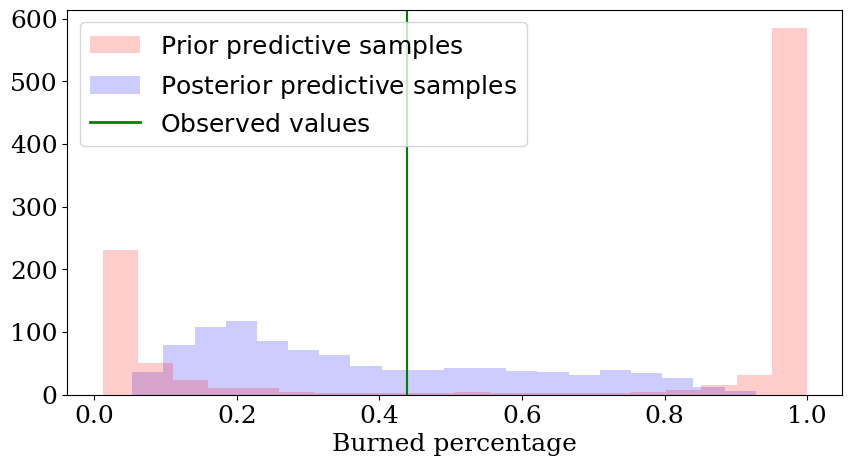

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(posterior_burned_percentage, bins=20, color='b', alpha=0.2)
plt.hist(prior_burned_percentage, bins=20, color='r', alpha=0.2)
plt.axvline(observation_burned_percentage, c='g')
plt.xlabel(r"Burned percentage", fontsize=18)
# plt.legend([r"Observed value", r"Prior predictive samples", r"Posterior predictive samples"], fontsize=18)

handles = [patches.Rectangle((0,0),0,0,facecolor='r',
                             label=r"${\rm Prior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           patches.Rectangle((0,0),0,0,facecolor='b',
                             label=r"${\rm Posterior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           Line2D([0], [0], color='g', label=r"${\rm Observed}$ ${\rm values}$", lw=2, linestyle="-")]

plt.legend(handles=handles, fontsize=18)

# Sensitivity Analysis

In [ ]:
file_name = "1716017330.7123892"
with open(f"../../exp_dir/fire/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

In [ ]:
from sbi4abm.sbi.analysis import ActiveSubspace, pairplot

posterior_samples = posterior.sample((200,))
_ = pairplot(posterior_samples, limits=[[0,1], [50,110]], figsize=(10, 10))

In [ ]:
sensitivity = ActiveSubspace(posterior)
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)